# Simulación de Siniestros con Neural Style Transfer
Este notebook aplica transferencia de estilo neural para simular visualmente diferentes tipos de siniestros en imágenes.

In [30]:
# Librerias
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image


## Generación de Máscaras Binarias por Tipo de Daño


 Procesando carpeta: /content/drive/MyDrive/Ejemplo_auto
 Procesando máscara: /content/drive/MyDrive/Ejemplo_auto/coche12_mask.png


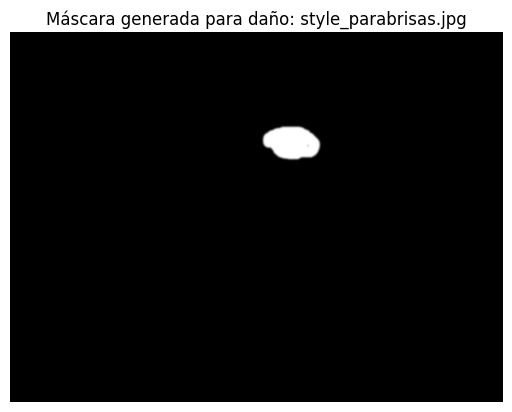

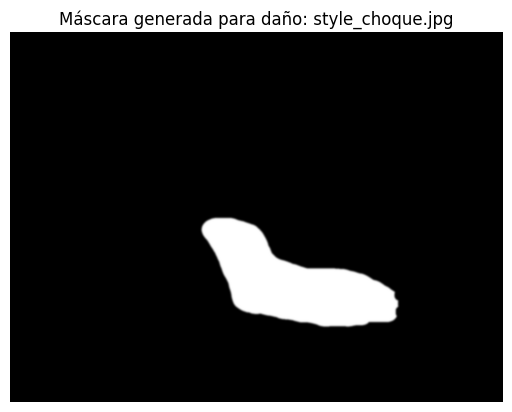

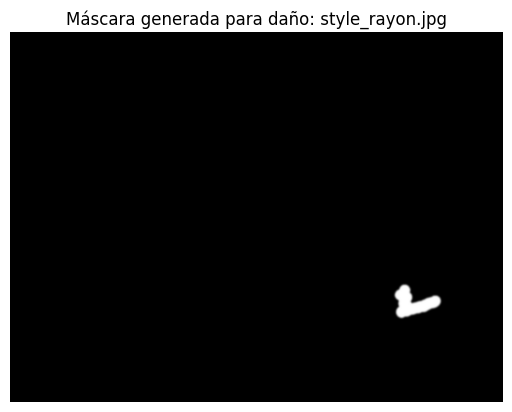

 Máscaras guardadas en la carpeta: /content/drive/MyDrive/Ejemplo_auto


 Procesando carpeta: /content/drive/MyDrive/Ejemplo_edificio
 Procesando máscara: /content/drive/MyDrive/Ejemplo_edificio/casa2_mask.png


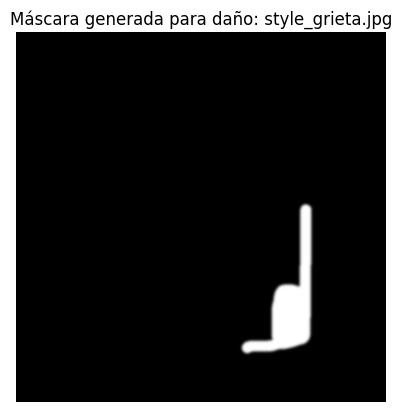

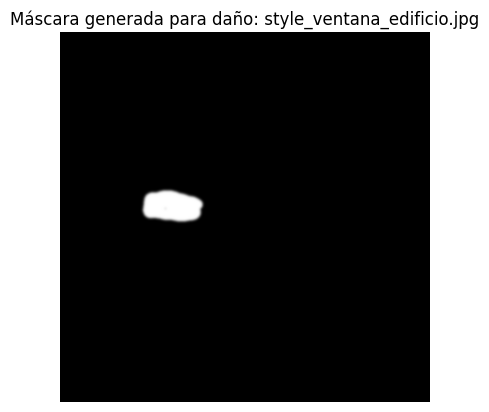

 Máscaras guardadas en la carpeta: /content/drive/MyDrive/Ejemplo_edificio

Todas las máscaras han sido generadas correctamente y guardadas en sus respectivas carpetas.


In [31]:
# Definir la carpeta donde están las imágenes de daño
damage_folder = "/content/drive/MyDrive/Ejemplos_danios"  # Cambia por la ruta correcta

# Asociar colores para cada tipo de daño
damage_classes = {
    (255, 102, 0): 'style_abolladura.jpg',
    (255, 0, 0): 'style_choque.jpg',
    (0, 255, 0): 'style_grieta.jpg',
    (255, 255, 0): 'style_incendio.jpg',
    (0, 153, 255): 'style_parabrisas.jpg',
    (255, 0, 255): 'style_rayon.jpg',
    (0, 255, 255): 'style_ventana_auto.jpg',
    (200, 200, 200): 'style_ventana_edificio.jpg'
}

# Definimos las carpetas donde están las máscaras
mask_folders = ["/content/drive/MyDrive/Ejemplo_auto",
                "/content/drive/MyDrive/Ejemplo_edificio"]

# Recorrer cada carpeta y procesar sus máscaras
for mask_folder in mask_folders:
    print(f"\n Procesando carpeta: {mask_folder}")

    mask_paths = [os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(('.png'))]

    for mask_path in mask_paths:
        print(f" Procesando máscara: {mask_path}")

        # Cargar la máscara multiclase
        mask_original = cv2.imread(mask_path)
        mask_original = cv2.cvtColor(mask_original, cv2.COLOR_BGR2RGB)

        # Detectar colores únicos en la máscara
        unique_colors = np.unique(mask_original.reshape(-1, mask_original.shape[2]), axis=0)

        # Filtrar colores que coincidan con `damage_classes`
        valid_colors = [tuple(color) for color in unique_colors if tuple(color) in damage_classes]

        # Obtener nombre base sin la extensión
        base_name = os.path.splitext(os.path.basename(mask_path))[0]  # Esto elimina la extensión original

        for color in valid_colors:
            damage_mask = (mask_original == color).all(axis=-1).astype(np.uint8) * 255  # Crear máscara binaria

            # Suavizar bordes
            damage_mask = cv2.GaussianBlur(damage_mask, (15, 15), 0)

            # Guarda la máscara en la misma carpeta que la imagen original
            # Limpiar el nombre del daño (quita '.jpg')
            damage_name = damage_classes[color]
            damage_name_clean = damage_name.replace(".jpg", "")

            # Guarda la máscara
            mask_path_output = os.path.join(mask_folder, f"{base_name}_{damage_name_clean}.png")
            cv2.imwrite(mask_path_output, damage_mask)

            # Mostrar la máscara generada
            plt.imshow(damage_mask, cmap="gray")
            plt.title(f"Máscara generada para daño: {damage_name}")
            plt.axis("off")
            plt.show()

        print(f" Máscaras guardadas en la carpeta: {mask_folder}\n")

print("Todas las máscaras han sido generadas correctamente y guardadas en sus respectivas carpetas.")

## Transferencia de Estilo Guiada por Máscara

In [32]:
def simular_siniestros(content_path, style_path, mask_path,output_base_path, name_image, mask_acumulada=None):

  # ----- Funciones auxiliares -----
  def load_img(path_to_img):
      max_dim = 512  # Para mantener la calidad
      img = Image.open(path_to_img)
      long = max(img.size)
      scale = max_dim / long
      img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)))
      img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.expand_dims(img, axis=0)
      return tf.keras.applications.vgg19.preprocess_input(img)

  def deprocess_img(processed_img):
      x = processed_img.copy()
      x = x.reshape((x.shape[1], x.shape[2], 3))
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      x = x[:, :, ::-1]  # Convertir de BGR a RGB

      return np.clip(x, 0, 255).astype('uint8')


  # ----- Carga imagen y de estilo -----
  content_image = load_img(content_path)
  style_image = load_img(style_path) # Textura del daño a aplicar


  # ----- Procesamiento de la máscara -----
  ## Redimensionar y mejorar máscara
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Cargar máscara en escala de grises
  mask = cv2.resize(mask, (content_image.shape[2], content_image.shape[1]))  # Ajustar tamaño


  # ----- Preparación de la máscara para la fusión de imágenes -----

  ## Binarizar para evitar tonos intermedios raros
  _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  ## Suavizar bordes para evitar pixelado duro
  mask_soft = cv2.GaussianBlur(mask_bin, (15, 15), 0)

  ## Normalizar a [0,1] y dar forma [1, H, W, 1]
  mask = mask_soft.astype(np.float32) / 255.0
  mask = np.expand_dims(mask, axis=(0, 3))  # [1, height, width, 1]


  # ----- Configuración del modelo VGG19 para transferencia de estilo -----

  # Crear modelo VGG y capas
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  # Capas utilizadas en el modelo
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

  # Número de capas
  num_content = len(content_layers)
  num_style = len(style_layers)

  def gram_matrix(input_tensor):
      channels = int(input_tensor.shape[-1])
      a = tf.reshape(input_tensor, [-1, channels])
      n = tf.shape(a)[0]
      gram = tf.matmul(a, a, transpose_a=True)
      return gram / tf.cast(n, tf.float32)






  # Obtener activaciones de estilo y contenido
  def get_model():
      outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
      return tf.keras.Model([vgg.input], outputs)

  def get_feature_representations(model, content_img, style_img):
      style_outputs = model(style_img)
      content_outputs = model(content_img)
      style_features = [gram_matrix(style_output) for style_output in style_outputs[:num_style]]
      content_features = [content_output for content_output in content_outputs[num_style:]]
      return style_features, content_features

  def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
      style_weight, content_weight = loss_weights
      model_outputs = model(init_image)

      style_output_features = model_outputs[:num_style]
      content_output_features = model_outputs[num_style:]

      style_score = 0
      content_score = 0

      for target_style, comb_style in zip(gram_style_features, style_output_features):
          gram_comb_style = gram_matrix(comb_style)
          style_score += tf.reduce_mean(tf.square(gram_comb_style - target_style))

      for target_content, comb_content in zip(content_features, content_output_features):
          content_score += tf.reduce_mean(tf.square(comb_content - target_content))

      # Ajusta pérdida por los pesos de estilo y contenido
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      return loss

  # Optimización
  @tf.function()
  def train_step(init_image, model, loss_weights, gram_style_features, content_features, optimizer):
      with tf.GradientTape() as tape:
          loss = compute_loss(model, loss_weights, init_image, gram_style_features, content_features)

      grad = tape.gradient(loss, init_image)
      optimizer.apply_gradients([(grad, init_image)])
      init_image.assign(tf.clip_by_value(init_image, -103.939, 255.0 - 103.939))
      return loss

  # Entrenamiento de Transferencia de Estil
  def run_style_transfer(content_path, style_path, mask, num_iterations=750,
                        content_weight=1e4, style_weight=1e2):
      model = get_model()
      for layer in model.layers:
          layer.trainable = False # Congela las capas de VGG19

      # Carga imágenes de contenido y estilo
      content_image = load_img(content_path)
      style_image = load_img(style_path)


      # Extrae características de estilo y contenido
      style_features, content_features = get_feature_representations(model, content_image, style_image)
      init_image = tf.Variable(content_image, dtype=tf.float32)

      opt = tf.optimizers.Adam(learning_rate=5.0)
      best_img = None
      best_loss = float('inf')

      loss_weights = (style_weight, content_weight)


      # Iteraciones de optimización

      for i in range(num_iterations):
          loss = train_step(init_image, model, loss_weights, style_features, content_features, opt)

          if loss < best_loss:
              best_loss = loss
              best_img = init_image.numpy()

          if i % 50 == 0:
              print(f"Iteración {i}, pérdida: {loss.numpy():.2f}")

      return best_img



  # Ejecutar transferencia de estilo
  stylized_result = run_style_transfer(content_path, style_path, mask)

  # Combinar con máscara
  content_img_np = deprocess_img(content_image.numpy())  # Imagen base
  stylized_img_np = deprocess_img(stylized_result)  # Imagen con el daño aplicado



  # Convierte máscara a formato de 3 canales para que coincida con la imagen
  mask_rgb = np.concatenate([mask]*3, axis=-1)

  # Fusiona la imagen base con la imagen dañada usando la máscara
  final_blend = (content_img_np * (1 - mask_rgb) + stylized_img_np * mask_rgb).astype('uint8')


  # Guarda la imagen generada
  ruta_guardado = os.path.join(output_base_path, f"{name_image}.jpg")
  plt.imsave(ruta_guardado, final_blend[0])
  print(f"Imagen guardada en: {ruta_guardado}")




  # Muestra el resultado

  plt.figure(figsize=(10,5))
  plt.imshow(final_blend[0])  # Quita la dimensión del batch
  plt.title("Daño localizado")
  plt.axis('off')
  plt.show()


  # Muestra la máscara aplicada
  plt.figure(figsize=(10,5))
  plt.imshow(mask[0, :, :, 0], cmap='gray')
  plt.title("Máscara aplicada")
  plt.axis('off')
  plt.show()

  # Acumular máscara
  if mask_acumulada is None:
      mask_acumulada = mask
  else:
      mask_acumulada = np.maximum(mask_acumulada, mask)  # Unión de áreas dañadas

  # Devolver la máscara acumulada actualizada
  return mask_acumulada




## Ejemplos de Simulación de Daños

### Ejemplo auto

In [33]:
# Definir rutas de carpetas
content_base_path = "/content/drive/MyDrive/Ejemplo_auto"
style_base_path = "/content/drive/MyDrive/Ejemplos_danios"
output_base_path = "/content/drive/MyDrive/Ejemplo_auto"

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_308']
Received: inputs=Tensor(shape=(1, 415, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_308']
Received: inputs=Tensor(shape=(1, 384, 512, 3))
  warnings.warn(msg)


Iteración 0, pérdida: 5571645800448.00
Iteración 50, pérdida: 82397192192.00
Iteración 100, pérdida: 32967143424.00
Iteración 150, pérdida: 22079057920.00
Iteración 200, pérdida: 16917209088.00
Iteración 250, pérdida: 14944274432.00
Iteración 300, pérdida: 19227834368.00
Iteración 350, pérdida: 11096119296.00
Iteración 400, pérdida: 10311131136.00
Iteración 450, pérdida: 11271662592.00
Iteración 500, pérdida: 36293574656.00
Iteración 550, pérdida: 12679246848.00
Iteración 600, pérdida: 17379307520.00
Iteración 650, pérdida: 8982351872.00
Iteración 700, pérdida: 8015667200.00
Imagen guardada en: /content/drive/MyDrive/Ejemplo_auto/auto12_choque.jpg


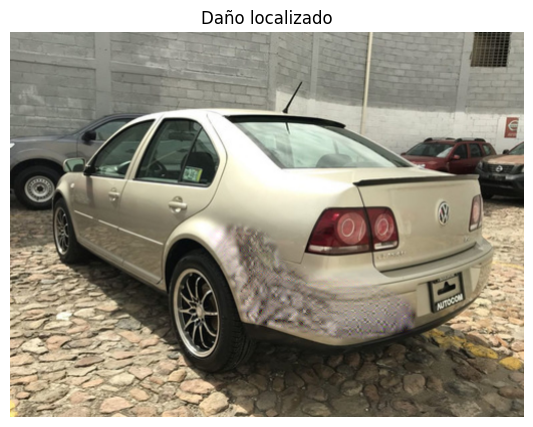

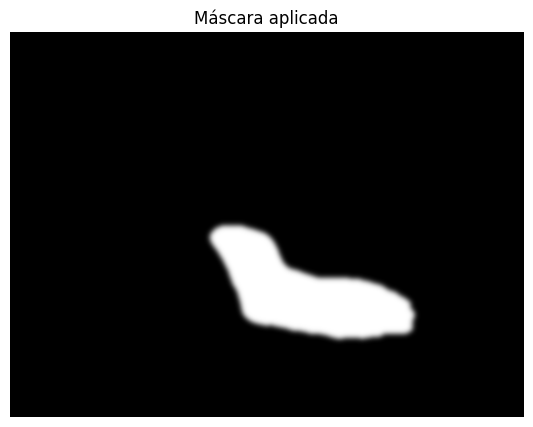

In [34]:
# Inicializar máscara global
mask_global = None

# Primer daño
content_path = os.path.join(content_base_path, "coche12.jpg")
style_path = os.path.join(style_base_path, "style_choque.jpg")
mask_path = os.path.join(content_base_path, "coche12_mask_style_choque.png")
name_image = "auto12_choque"

mask_global = simular_siniestros(content_path, style_path, mask_path, output_base_path, name_image, mask_acumulada=mask_global)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_330']
Received: inputs=Tensor(shape=(1, 510, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_330']
Received: inputs=Tensor(shape=(1, 384, 512, 3))
  warnings.warn(msg)


Iteración 0, pérdida: 7498571972608.00
Iteración 50, pérdida: 75298275328.00
Iteración 100, pérdida: 36119375872.00
Iteración 150, pérdida: 24671737856.00
Iteración 200, pérdida: 18745812992.00
Iteración 250, pérdida: 15001436160.00
Iteración 300, pérdida: 12617194496.00
Iteración 350, pérdida: 13305291776.00
Iteración 400, pérdida: 9504173056.00
Iteración 450, pérdida: 8669413376.00
Iteración 500, pérdida: 7842027520.00
Iteración 550, pérdida: 7840446976.00
Iteración 600, pérdida: 13548946432.00
Iteración 650, pérdida: 6970837504.00
Iteración 700, pérdida: 6113757696.00
Imagen guardada en: /content/drive/MyDrive/Ejemplo_auto/auto12_choque_parabrisas.jpg


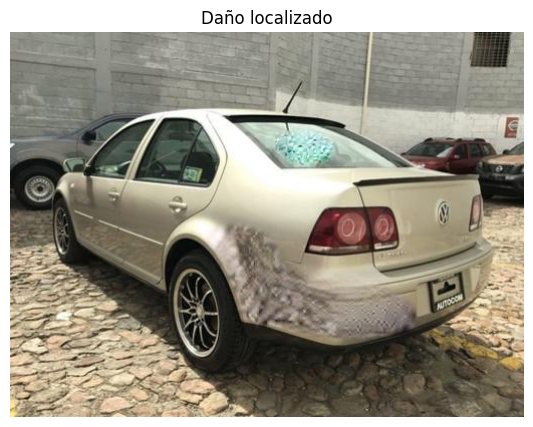

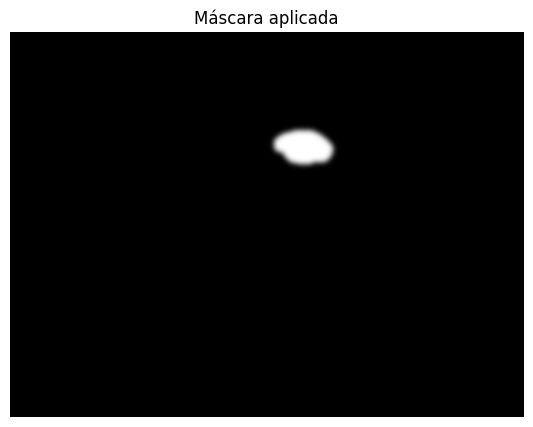

In [35]:
# Segundo daño
content_path2 = os.path.join(content_base_path, "auto12_choque.jpg")
style_path2 = os.path.join(style_base_path, "style_parabrisas.jpg")
mask_path2 = os.path.join(content_base_path, "coche12_mask_style_parabrisas.png")
name_image2 = "auto12_choque_parabrisas"

mask_global = simular_siniestros(content_path2, style_path2, mask_path2, output_base_path, name_image2, mask_acumulada=mask_global)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_352']
Received: inputs=Tensor(shape=(1, 383, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_352']
Received: inputs=Tensor(shape=(1, 384, 512, 3))
  warnings.warn(msg)


Iteración 0, pérdida: 1518161231872.00
Iteración 50, pérdida: 36879818752.00
Iteración 100, pérdida: 17158275072.00
Iteración 150, pérdida: 39561613312.00
Iteración 200, pérdida: 12158736384.00
Iteración 250, pérdida: 23915380736.00
Iteración 300, pérdida: 11785159680.00
Iteración 350, pérdida: 8226883584.00
Iteración 400, pérdida: 93096599552.00
Iteración 450, pérdida: 12032873472.00
Iteración 500, pérdida: 12487362560.00
Iteración 550, pérdida: 9747968000.00
Iteración 600, pérdida: 7212375040.00
Iteración 650, pérdida: 38885650432.00
Iteración 700, pérdida: 9597822976.00
Imagen guardada en: /content/drive/MyDrive/Ejemplo_auto/auto12_choque_parabrisas_rayon.jpg


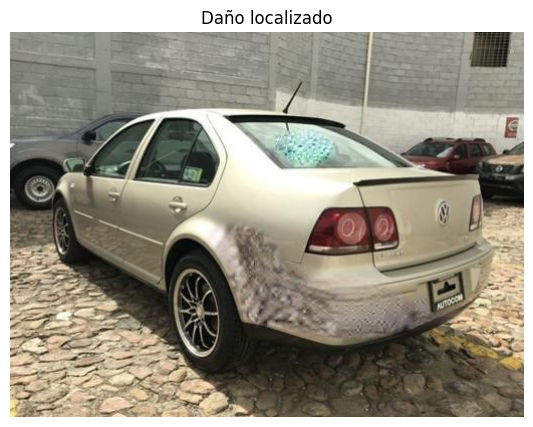

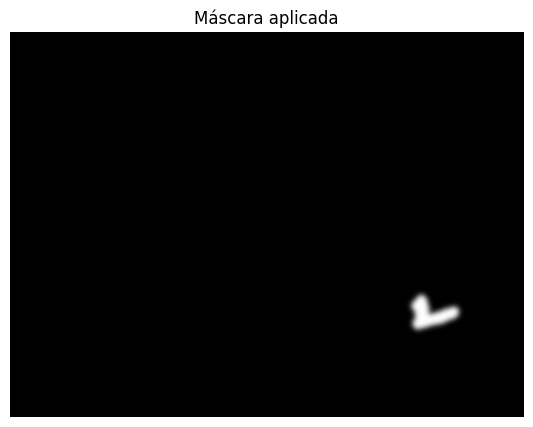

In [36]:
# Tercer daño
content_path3 = os.path.join(content_base_path, "auto12_choque_parabrisas.jpg")
style_path3 = os.path.join(style_base_path, "style_rayon.jpg")
mask_path3 = os.path.join(content_base_path, "coche12_mask_style_rayon.png")
name_image3 = "auto12_choque_parabrisas_rayon"

mask_global = simular_siniestros(content_path3, style_path3, mask_path3, output_base_path, name_image3, mask_acumulada=mask_global)

In [37]:
# Mostrar severidad total
area_danada = np.sum(mask_global)
area_total = mask_global.shape[1] * mask_global.shape[2]
porcentaje_danio = (area_danada / area_total) * 100

print(f"\n Daño acumulado total: {porcentaje_danio:.2f}%")

if porcentaje_danio < 10:
    print("Nivel de daño: LEVE")
elif porcentaje_danio < 30:
    print("Nivel de daño: MODERADO")
else:
    print("Nivel de daño: SEVERO")



 Daño acumulado total: 7.24%
Nivel de daño: LEVE


### Ejemplo edificio

In [38]:
# Definir rutas de carpetas
content_base_path_2 = "/content/drive/MyDrive/Ejemplo_edificio"
style_base_path_2 = "/content/drive/MyDrive/Ejemplos_danios"
output_base_path_2 = "/content/drive/MyDrive/Ejemplo_edificio"

In [39]:
# Inicializar máscara global
mask_global = None

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_374']
Received: inputs=Tensor(shape=(1, 294, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_374']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


Iteración 0, pérdida: 3915711250432.00
Iteración 50, pérdida: 43988791296.00
Iteración 100, pérdida: 19631730688.00
Iteración 150, pérdida: 13588284416.00
Iteración 200, pérdida: 11206801408.00
Iteración 250, pérdida: 9313293312.00
Iteración 300, pérdida: 9591005184.00
Iteración 350, pérdida: 7687220224.00
Iteración 400, pérdida: 27146323968.00
Iteración 450, pérdida: 6421006848.00
Iteración 500, pérdida: 7649585152.00
Iteración 550, pérdida: 6397171200.00
Iteración 600, pérdida: 5405196288.00
Iteración 650, pérdida: 52557987840.00
Iteración 700, pérdida: 11655936000.00
Imagen guardada en: /content/drive/MyDrive/Ejemplo_edificio/casa2_grieta.jpg


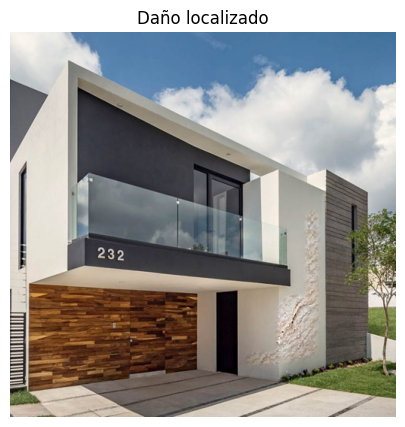

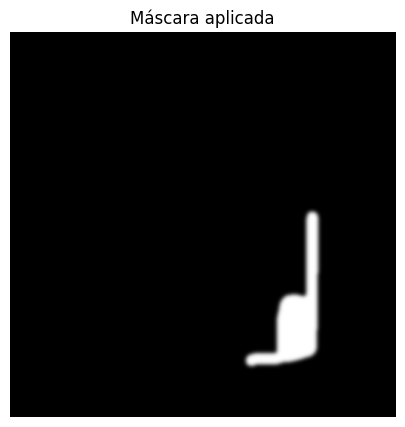

In [40]:
# Ajustar las rutas de entrada

# Primer daño
content_path4 = os.path.join(content_base_path_2, "casa2.jpg")
style_path4 = os.path.join(style_base_path_2, "style_grieta.jpg")
mask_path4 = os.path.join(content_base_path_2, "casa2_mask_style_grieta.png")
name_image4 = "casa2_grieta"

mask_global = simular_siniestros(content_path4, style_path4, mask_path4, output_base_path_2, name_image4, mask_acumulada=mask_global)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_396']
Received: inputs=Tensor(shape=(1, 294, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_396']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


Iteración 0, pérdida: 3604171980800.00
Iteración 50, pérdida: 40124743680.00
Iteración 100, pérdida: 18194415616.00
Iteración 150, pérdida: 12712572928.00
Iteración 200, pérdida: 10274800640.00
Iteración 250, pérdida: 9154814976.00
Iteración 300, pérdida: 8613142528.00
Iteración 350, pérdida: 6953972736.00
Iteración 400, pérdida: 7901562368.00
Iteración 450, pérdida: 6440030720.00
Iteración 500, pérdida: 14880959488.00
Iteración 550, pérdida: 6488724992.00
Iteración 600, pérdida: 15146893312.00
Iteración 650, pérdida: 5449461248.00
Iteración 700, pérdida: 4757275136.00
Imagen guardada en: /content/drive/MyDrive/Ejemplo_edificio/casa2_grieta_ventana.jpg


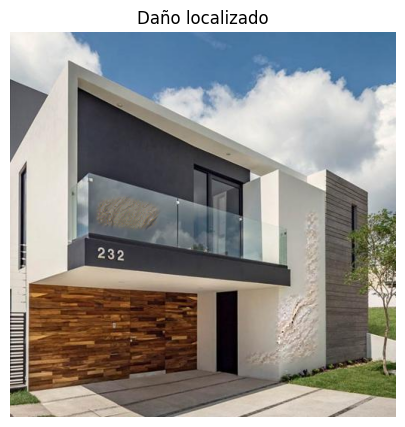

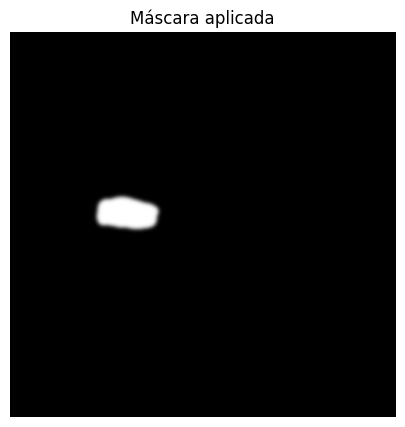

In [41]:
# Segundo daño
content_path5 = os.path.join(content_base_path_2, "casa2_grieta.jpg")
style_path5 = os.path.join(style_base_path_2, "style_grieta.jpg")
mask_path5 = os.path.join(content_base_path_2, "casa2_mask_style_ventana_edificio.png")
name_image5 = "casa2_grieta_ventana"


mask_global = simular_siniestros(content_path5, style_path5, mask_path5, output_base_path_2, name_image5, mask_acumulada=mask_global)

In [42]:
# Mostrar severidad total
area_danada = np.sum(mask_global)
area_total = mask_global.shape[1] * mask_global.shape[2]
porcentaje_danio = (area_danada / area_total) * 100

print(f"\n Daño acumulado total: {porcentaje_danio:.2f}%")

if porcentaje_danio < 10:
    print("Nivel de daño: LEVE")
elif porcentaje_danio < 30:
    print("Nivel de daño: MODERADO")
else:
    print("Nivel de daño: SEVERO")


 Daño acumulado total: 3.67%
Nivel de daño: LEVE
